# Imports

In [1]:
import sys
import os
import os.path as op
from glob import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm

pd.options.display.max_rows = 100
pd.options.display.max_columns = 999
import statsmodels.api as sm

sys.path.append(op.join(op.expanduser("~"), "code", "style"))
from colors import get_colors

co, palettes = get_colors()

sys.path.append("/home/mac/dschonhaut/code")
from general.basic.config import get_plot_defaults, set_rcparams

mpl.rcParams = set_rcparams(mpl.rcParams)
mpl.rcParams["axes.grid"] = False
d = get_plot_defaults()
co = d.get("colors", None)
colws = d.get("colws", None)
font = d.get("font", None)
lws = d.get("lws", None)
pad = d.get("pad", None)
palettes = d.get("palettes", None)

# Load and format data

In [2]:
def frglob(topdir, base_starts="", base_ends="", base_contains="", path_contains=""):
    """Return a list of all files nested under topdir that meet criteria

    A fast, recursive glob search.
    """

    def _path_recurse(
        path, base_starts="", base_ends="", base_contains="", path_contains=""
    ):
        with os.scandir(path) as entries:
            for entry in entries:
                if entry.is_dir():
                    _path_recurse(
                        entry.path, base_starts, base_ends, base_contains, path_contains
                    )
                elif entry.is_file():
                    if base_starts:
                        if not entry.name.startswith(base_starts):
                            continue
                    if base_ends:
                        if not entry.name.endswith(base_ends):
                            continue
                    if base_contains:
                        if base_contains not in entry.name:
                            continue
                    if path_contains:
                        if path_contains not in op.relpath(
                            op.dirname(entry.path), path
                        ):
                            continue
                    outfiles.append(entry.path)

    outfiles = []
    _path_recurse(topdir, base_starts, base_ends, base_contains, path_contains)
    return outfiles

In [3]:
# Define project paths
proj_dir = "/mnt/coredata/processing/leads"
code_dir = op.join(proj_dir, "code")
data_dir = op.join(proj_dir, "data")
extraction_dir = op.join(data_dir, "extraction")
proc_dir = op.join(data_dir, "processed")

In [24]:
# Find all processed MRI directories.
mri_dirs = []
with os.scandir(proc_dir) as entries:
    for entry in entries:
        if entry.is_dir():
            subj_dir = entry
            with os.scandir(subj_dir) as subj_entries:
                for subj_entry in subj_entries:
                    if subj_entry.is_dir() and subj_entry.name.startswith("MRI-T1"):
                        mri_dirs.append(subj_entry.path)

print(f"{len(mri_dirs):,} processed MRIs")

1,261 processed MRIs


In [25]:
# Find all processed PET directories.
pet_dirs = []
with os.scandir(proc_dir) as entries:
    for entry in entries:
        if entry.is_dir():
            subj_dir = entry
            with os.scandir(subj_dir) as subj_entries:
                for subj_entry in subj_entries:
                    if subj_entry.is_dir() and not subj_entry.name.startswith("MRI-T1"):
                        pet_dirs.append(subj_entry.path)

print(f"{len(pet_dirs):,} processed PET scans")

2,112 processed PET scans


In [7]:
# Find all processed MRI directories
mri_dirs = frglob(proc_dir, path_contains="MRI-T1_")

KeyboardInterrupt: 

In [6]:
mri_dirs

[]

In [4]:
# Find all ROI extraction files in 'processed'
cl_files = frglob(proc_dir, base_ends="amyloid-cortical-summary.csv")
fbb_wcbl_files = frglob(proc_dir, base_ends="suvr-wcbl_roi-extractions.csv")
ftp_infcblgm_files = frglob(proc_dir, base_ends="suvr-infcblgm_roi-extractions.csv")
fdg_pons_files = frglob(proc_dir, base_ends="suvr-pons_roi-extractions.csv")

fbb_sf_files = frglob(proc_dir, base_contains="FBB", base_ends="ref-region-means.csv")
ftp_sf_files = frglob(proc_dir, base_contains="FTP", base_ends="ref-region-means.csv")
fdg_sf_files = frglob(proc_dir, base_contains="FDG", base_ends="ref-region-means.csv")

print(f"Found {len(cl_files)} CL files")
print(f"Found {len(fbb_wcbl_files)} FBB files")
print(f"Found {len(fbb_sf_files)} FBB scaling factor files")
print(f"Found {len(ftp_infcblgm_files)} FTP SUVR infcblgm files")
print(f"Found {len(ftp_sf_files)} FTP scaling factor files")
print(f"Found {len(fdg_pons_files)} FDG SUVR pons files")
print(f"Found {len(fdg_sf_files)} FDG scaling factor files")

Found 986 CL files
Found 986 FBB files
Found 986 FBB scaling factor files
Found 952 FTP SUVR infcblgm files
Found 952 FTP scaling factor files
Found 158 FDG SUVR pons files
Found 158 FDG scaling factor files


In [5]:
def format_cl(filepath):
    df = pd.read_csv(filepath)
    df["image_file"] = df["image_file"].apply(op.basename)
    df.insert(0, "subj", df["image_file"].apply(lambda x: x.split("_")[0][1:]))
    df.insert(1, "pet_date", df["image_file"].apply(lambda x: x.split("_")[2]))
    df = df.loc[
        df["image_file"].apply(lambda x: x.split("_")[3].startswith("suvr-wcbl")), :
    ]
    df = df.rename(
        columns={
            "mean_suvr": "cortical_summary_suvr_6mm",
            "centiloids": "centiloid_6mm",
        }
    )
    df = df.drop(columns=["image_file", "mask_file"])
    return df


def format_fbb(filepath):
    df = pd.read_csv(filepath)
    df["image_file"] = df["image_file"].apply(op.basename)
    df.insert(0, "subj", df["image_file"].apply(lambda x: x.split("_")[0][1:]))
    df.insert(1, "pet_date", df["image_file"].apply(lambda x: x.split("_")[2]))
    df = df.loc[df["roi"] == "amyloid_cortical_summary", :]
    df = df.rename(
        columns={
            "mean": "cortical_summary_suvr_6mm",
            "voxel_count": "cortical_summary_voxels_6mm",
        }
    )
    df = df.drop(columns=["image_file", "roi_file", "roi"])
    return df


def format_ftp(filepath):
    df = pd.read_csv(filepath)
    df["image_file"] = df["image_file"].apply(op.basename)
    df.insert(0, "subj", df["image_file"].apply(lambda x: x.split("_")[0][1:]))
    df.insert(1, "pet_date", df["image_file"].apply(lambda x: x.split("_")[2]))
    df = df.loc[df["roi"] == "meta_temporal", :]
    df = df.rename(
        columns={
            "mean": "meta_temporal_suvr_6mm",
            "voxel_count": "meta_temporal_voxels_6mm",
        }
    )
    df = df.drop(columns=["image_file", "roi_file", "roi"])
    return df


def format_fdg(filepath):
    df = pd.read_csv(filepath)
    df["image_file"] = df["image_file"].apply(op.basename)
    df.insert(0, "subj", df["image_file"].apply(lambda x: x.split("_")[0][1:]))
    df.insert(1, "pet_date", df["image_file"].apply(lambda x: x.split("_")[2]))
    df = df.loc[df["roi"] == "ctx-lh-precuneus", :]
    df = df.rename(
        columns={
            "mean": "lh_precuneus_suvr_6mm",
            "voxel_count": "lh_precuneus_voxels_6mm",
        }
    )
    df = df.drop(columns=["image_file", "roi_file", "roi"])
    return df

In [6]:
# Import the 6mm LEADS dataframes
cl_6mm = pd.concat(pd.Series(cl_files).apply(format_cl).values, axis=0).reset_index(
    drop=True
)
fbb_6mm = pd.concat(
    pd.Series(fbb_wcbl_files).apply(format_fbb).values, axis=0
).reset_index(drop=True)
ftp_6mm = pd.concat(
    pd.Series(ftp_infcblgm_files).apply(format_ftp).values, axis=0
).reset_index(drop=True)
fdg_6mm = pd.concat(
    pd.Series(fdg_pons_files).apply(format_fdg).values, axis=0
).reset_index(drop=True)

print(f"cl_6mm: {cl_6mm.shape}")
print(f"fbb_6mm: {fbb_6mm.shape}")
print(f"ftp_6mm: {ftp_6mm.shape}")
print(f"fdg_6mm: {fdg_6mm.shape}")

cl_6mm: (986, 4)
fbb_6mm: (986, 4)
ftp_6mm: (952, 4)
fdg_6mm: (158, 4)


In [7]:
# Load and format the 8mm LEADS data
keep_cohort = ["EOAD", "EOnonAD", "CN"]

# Load the 8mm LEADS data
dat_8mm_dir = "/home/mac/dschonhaut/projects/leads/6v8mm"
fbb_8mmf = op.join(
    dat_8mm_dir, "QuarterlyReport122023_FBB_PETCore_Analysis_2023-12-17.csv"
)
ftp_8mmf = op.join(
    dat_8mm_dir, "QuarterlyReport122023_FTP_PETCore_Analysis_2023-12-17.csv"
)
fdg_8mmf = op.join(
    dat_8mm_dir, "QuarterlyReport122023_FDG_PETCore_Analysis_2023-12-17.csv"
)

fbb_8mm = pd.read_csv(fbb_8mmf)
ftp_8mm = pd.read_csv(ftp_8mmf)
fdg_8mm = pd.read_csv(fdg_8mmf)

print(f"fbb_8mm: {fbb_8mm.shape}")
print(f"ftp_8mm: {ftp_8mm.shape}")
print(f"fdg_8mm: {fdg_8mm.shape}")

fbb_8mm: (892, 253)
ftp_8mm: (866, 247)
fdg_8mm: (146, 232)


In [8]:
# Format the 8mm LEADS dataframes
keep_cohort = ["EOAD", "EOnonAD", "CN"]

# FBB
keep_cols = [
    "subj",
    "pet_date",
    "cohort",
    "cortical_summary_suvr_8mm",
    "centiloid_8mm",
]
fbb_8mm = (
    fbb_8mm.query("CohortAssgn==@keep_cohort")
    .rename(
        columns={
            "ID": "subj",
            "FBBPET_Date": "pet_date",
            "CohortAssgn": "cohort",
            "MRIBASED_Composite_SUVR": "cortical_summary_suvr_8mm",
            "MRIBASED_Composite_Centiloids": "centiloid_8mm",
        }
    )
    .loc[:, keep_cols]
)

# FTP
keep_cols = [
    "subj",
    "pet_date",
    "cohort",
    "meta_temporal_suvr_8mm",
    "meta_temporal_voxels_8mm",
]
ftp_8mm = (
    ftp_8mm.query("CohortAssgn==@keep_cohort")
    .rename(
        columns={
            "ID": "subj",
            "FTPPET_Date": "pet_date",
            "CohortAssgn": "cohort",
            "MetaROI_MRIBASED_SUVR": "meta_temporal_suvr_8mm",
            "MetaROI_ClustSize": "meta_temporal_voxels_8mm",
        }
    )
    .loc[:, keep_cols]
)

# FDG
keep_cols = [
    "subj",
    "pet_date",
    "cohort",
    "lh_precuneus_suvr_8mm",
    "lh_precuneus_voxels_8mm",
]
fdg_8mm = (
    fdg_8mm.query("CohortAssgn==@keep_cohort")
    .rename(
        columns={
            "ID": "subj",
            "FDGPET_Date": "pet_date",
            "CohortAssgn": "cohort",
            "ctx_lh_precuneus_MRIBASED_SUVR": "lh_precuneus_suvr_8mm",
            "ctx_lh_precuneus_ClustSize": "lh_precuneus_voxels_8mm",
        }
    )
    .loc[:, keep_cols]
)

print(f"fbb_8mm: {fbb_8mm.shape}")
print(f"ftp_8mm: {ftp_8mm.shape}")
print(f"fdg_8mm: {fdg_8mm.shape}")

fbb_8mm: (892, 5)
ftp_8mm: (861, 5)
fdg_8mm: (144, 5)


In [9]:
# Merge the 6mm and 8mm dataframes
fbb_dat = fbb_8mm.merge(cl_6mm, on=["subj", "pet_date"], how="inner")
ftp_dat = ftp_8mm.merge(ftp_6mm, on=["subj", "pet_date"], how="inner")
fdg_dat = fdg_8mm.merge(fdg_6mm, on=["subj", "pet_date"], how="inner")

# Remove scans after 2023-09-30
fbb_dat["pet_date"] = pd.to_datetime(fbb_dat["pet_date"])
ftp_dat["pet_date"] = pd.to_datetime(ftp_dat["pet_date"])
fdg_dat["pet_date"] = pd.to_datetime(fdg_dat["pet_date"])

qry = "pet_date<'2023-09-30'"
fbb_dat = fbb_dat.query(qry).sort_values(["subj", "pet_date"]).reset_index(drop=True)
ftp_dat = ftp_dat.query(qry).sort_values(["subj", "pet_date"]).reset_index(drop=True)
fdg_dat = fdg_dat.query(qry).sort_values(["subj", "pet_date"]).reset_index(drop=True)

print(f"fbb_dat: {fbb_dat.shape}")
print(f"ftp_dat: {ftp_dat.shape}")
print(f"fdg_dat: {fdg_dat.shape}")

fbb_dat: (867, 7)
ftp_dat: (839, 7)
fdg_dat: (137, 7)


In [118]:
print(
    np.min(fbb_dat[["centiloid_6mm", "centiloid_8mm"]]),
    np.max(fbb_dat[["centiloid_6mm", "centiloid_8mm"]]),
    np.min(ftp_dat[["meta_temporal_suvr_6mm", "meta_temporal_suvr_8mm"]]),
    np.max(ftp_dat[["meta_temporal_suvr_6mm", "meta_temporal_suvr_8mm"]]),
    np.min(fdg_dat[["lh_precuneus_suvr_6mm", "lh_precuneus_suvr_8mm"]]),
    np.max(fdg_dat[["lh_precuneus_suvr_6mm", "lh_precuneus_suvr_8mm"]]),
    sep="\n",
)

-21.3289364193698
190.385229254869
0.9787722
4.0525427
1.25681371215914
2.7712202


In [159]:
import general.basic.config
from importlib import reload

reload(general.basic.config)
from general.basic.config import get_plot_defaults, set_rcparams

mpl.rcParams = set_rcparams(mpl.rcParams)
mpl.rcParams["axes.grid"] = False
mpl.rcParams["font.sans-serif"] = "DejaVu Sans"
d = get_plot_defaults()
co = d.get("colors", None)
colws = d.get("colws", None)
font = d.get("font", None)
lws = d.get("lws", None)
pad = d.get("pad", None)
palettes = d.get("palettes", None)

Saved /home/mac/dschonhaut/projects/leads/6v8mm/leads_6v8mm_scatter.pdf


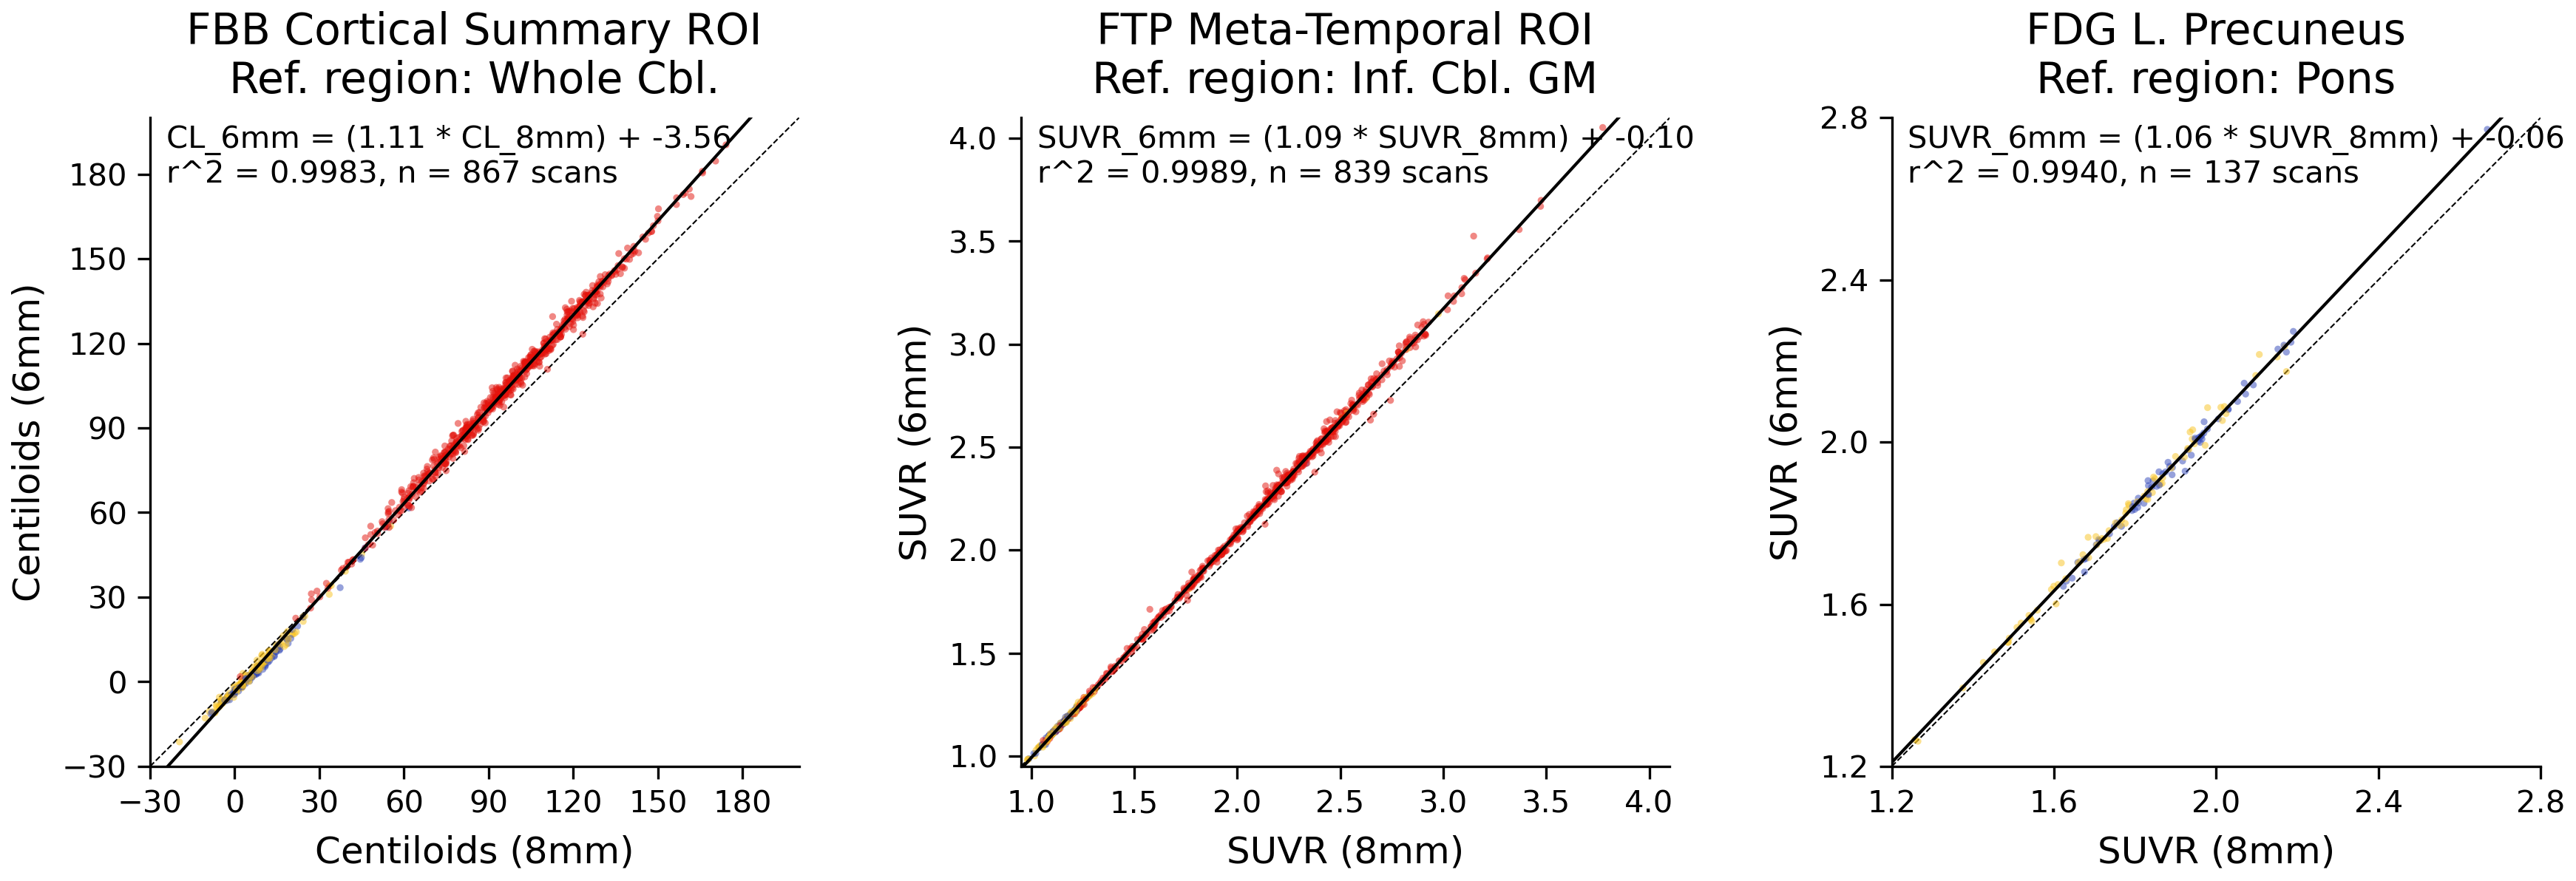

In [12]:
# make a 3-panel figure
scatter_size = 5
scatter_alpha = 0.5
plot_lw = 1
spine_lw = 0.5
palette = [co["b"], co["r"], co["y"]]
save_fig = 0

# ----------------------------------
fig, ax = plt.subplots(1, 3, figsize=(12, 4), dpi=300)
ax = np.ravel(ax)

# ----------------------------------
iax = 0
_ax = ax[iax]
sns.scatterplot(
    x="centiloid_8mm",
    y="centiloid_6mm",
    data=fbb_dat,
    hue="cohort",
    s=scatter_size,
    alpha=scatter_alpha,
    lw=0,
    palette=palette,
    ax=_ax,
    legend=False,
)
lim = [-30, 200]
_ax.plot(lim, lim, color="k", lw=spine_lw, ls='--', zorder=0)
ticks = np.arange(-30, 201, 30)
_ax.set_xlim(lim)
_ax.set_ylim(lim)
_ax.set_xticks(ticks)
_ax.set_yticks(ticks)
_ax.set_xlabel("Centiloids (8mm)")
_ax.set_ylabel("Centiloids (6mm)")
_ax.set_title("FBB Cortical Summary ROI\nRef. region: Whole Cbl.")
result = stats.linregress(fbb_dat["centiloid_8mm"], fbb_dat["centiloid_6mm"])
slope = result.slope
icpt = result.intercept
rval = result.rvalue
_ax.plot(lim, (np.array(lim) * slope) + icpt, color="k", lw=plot_lw, zorder=1)
annot = "CL_6mm = ({:.2f} * CL_8mm) + {:.2f}\nr^2 = {:.4f}, n = {} scans".format(
    slope, icpt, rval**2, fbb_dat.shape[0]
)
_ax.annotate(annot, (.025, 0.9), xycoords="axes fraction")

# ----------------------------------
iax = 1
_ax = ax[iax]
sns.scatterplot(
    x="meta_temporal_suvr_8mm",
    y="meta_temporal_suvr_6mm",
    data=ftp_dat,
    hue="cohort",
    s=scatter_size,
    alpha=scatter_alpha,
    lw=0,
    palette=palette,
    ax=_ax,
    legend=False,
)
lim = [0.95, 4.1]
_ax.plot(lim, lim, color="k", lw=spine_lw, ls='--', zorder=0)
ticks = np.arange(1, 4.01, 0.5)
_ax.set_xlim(lim)
_ax.set_ylim(lim)
_ax.set_xticks(ticks)
_ax.set_yticks(ticks)
_ax.set_xlabel("SUVR (8mm)")
_ax.set_ylabel("SUVR (6mm)")
_ax.set_title("FTP Meta-Temporal ROI\nRef. region: Inf. Cbl. GM")
result = stats.linregress(
    ftp_dat["meta_temporal_suvr_8mm"], ftp_dat["meta_temporal_suvr_6mm"]
)
slope = result.slope
icpt = result.intercept
rval = result.rvalue
_ax.plot(lim, (np.array(lim) * slope) + icpt, color="k", lw=plot_lw, zorder=1)
annot = "SUVR_6mm = ({:.2f} * SUVR_8mm) + {:.2f}\nr^2 = {:.4f}, n = {} scans".format(
    slope, icpt, rval**2, ftp_dat.shape[0]
)
_ax.annotate(annot, (0.025, 0.9), xycoords="axes fraction")

# ----------------------------------
iax = 2
_ax = ax[iax]
sns.scatterplot(
    x="lh_precuneus_suvr_8mm",
    y="lh_precuneus_suvr_6mm",
    data=fdg_dat,
    hue="cohort",
    s=scatter_size,
    alpha=scatter_alpha,
    lw=0,
    palette=[palette[0], palette[2]],
    ax=_ax,
    legend=False
)
lim = [1.2, 2.8]
_ax.plot(lim, lim, color="k", lw=spine_lw, ls='--', zorder=0)
ticks = np.arange(1.2, 2.81, 0.4)
_ax.set_xlim(lim)
_ax.set_ylim(lim)
_ax.set_xticks(ticks)
_ax.set_yticks(ticks)
_ax.set_xlabel("SUVR (8mm)")
_ax.set_ylabel("SUVR (6mm)")
_ax.set_title("FDG L. Precuneus\nRef. region: Pons")
result = stats.linregress(
    fdg_dat["lh_precuneus_suvr_8mm"], fdg_dat["lh_precuneus_suvr_6mm"]
)
slope = result.slope
icpt = result.intercept
rval = result.rvalue
_ax.plot(lim, (np.array(lim) * slope) + icpt, color="k", lw=plot_lw, zorder=1)
annot = "SUVR_6mm = ({:.2f} * SUVR_8mm) + {:.2f}\nr^2 = {:.4f}, n = {} scans".format(
    slope, icpt, rval**2, fdg_dat.shape[0]
)
_ax.annotate(annot, (0.025, 0.9), xycoords="axes fraction")


# Set equal aspect for all axes, and draw a y=x line
for _ax in ax:
    _ax.set_aspect("equal")

fig.tight_layout()

# Save the figure
if save_fig:
# figf = "/home/mac/dschonhaut/projects/leads/6v8mm/leads_6v8mm_scatter.pdf"
# fig.savefig(figf)
# print(f"Saved {figf}")